<a href="https://colab.research.google.com/github/TBG-Vassiliev/ProgFonc/blob/main/Time_series_Nicolas_Ulysse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## To do :    
- Vérifier les réponses  pour la partie 1
- Corriger l erreur du 2.4 et 2.8 (le dataset n a pas de probleme de d unicite)
- Ajouter la peridode de une semaine et comparer les resultat
- Faire la fin de l analyse

## done :
- (Répartir le code en sous-blocs)
- Faire la partie 2

In [2]:
# Chargement des librairies nécessaires
library(stats)
install.packages("forecast")
library(forecast)
library(tseries)
library(forecast)
library(ggplot2)
install.packages("lubridate")
library(lubridate)
library(zoo)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Partie 1 : Simulation

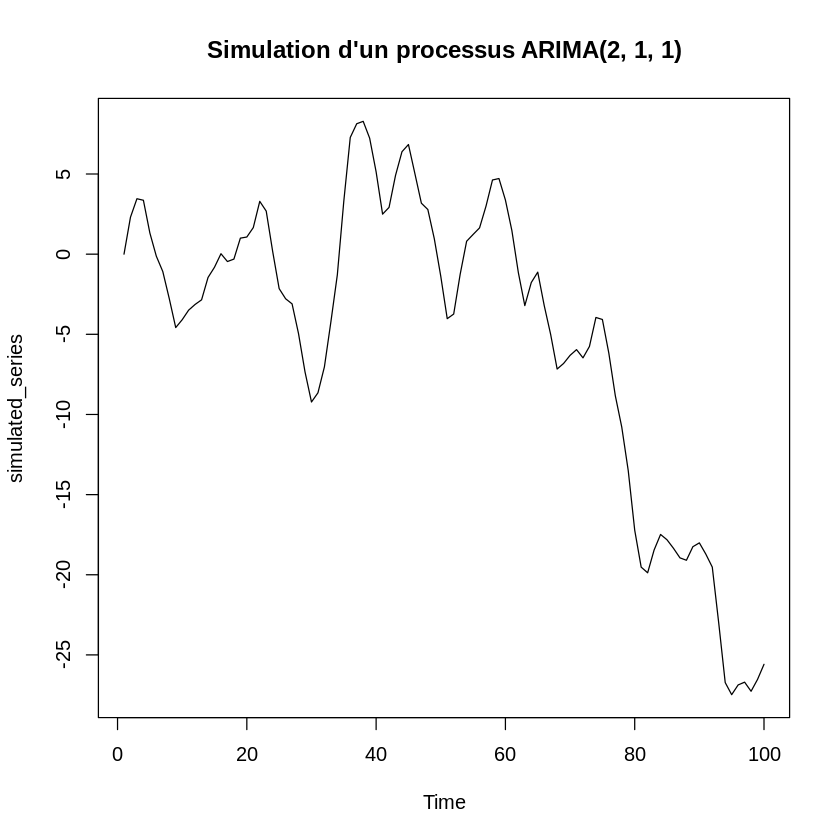

In [16]:
Arima_sim <- function(n, p, d, q, ar_coeffs, ma_coeffs, sigma = 1) {
  # n : longueur de la série
  # p : ordre du processus AR
  # d : degré de différenciation
  # q : ordre du processus MA
  # ar_coeffs : coefficients du modèle AR
  # ma_coeffs : coefficients du modèle MA
  # sigma : écart type de l'innovation (bruit blanc)

  # Initialisation du bruit blanc (innovations)
  innovations <- rnorm(n + q, mean = 0, sd = sigma)

  # Initialisation de la série avec des zéros (pour éviter des valeurs manquantes au début)
  y <- numeric(n + q)

  # Simulation du processus ARMA(p, q)
  for (t in (max(p, q) + 1):(n + q)) {
    # Partie AR: somme des p observations précédentes pondérées par les coefficients AR
    ar_part <- 0
    if (p > 0) {
      for (i in 1:p) {
        ar_part <- ar_part + ar_coeffs[i] * y[t - i]
      }
    }

    # Partie MA: somme des q innovations précédentes pondérées par les coefficients MA
    ma_part <- 0
    if (q > 0) {
      for (j in 1:q) {
        ma_part <- ma_part + ma_coeffs[j] * innovations[t - j]
      }
    }

    # Génération de la nouvelle observation
    y[t] <- ar_part + ma_part + innovations[t]
  }

  # Retrait des premiers q éléments utilisés pour l'amorçage
  y <- y[(q + 1):(n + q)]

  # Intégration (différenciation inverse) pour obtenir un processus ARIMA
  if (d > 0) {
    for (i in 1:d) {
      y <- cumsum(y)  # Cumul des différences pour inverser la différenciation
    }
  }

  return(y)
}

# Exemple d'utilisation :
n <- 100  # Longueur de la série
p <- 2    # Ordre du processus AR
d <- 1    # Degré de différenciation
q <- 1    # Ordre du processus MA
ar_coeffs <- c(0.5, -0.3)  # Coefficients AR
ma_coeffs <- c(0.4)        # Coefficients MA
sigma <- 1  # Écart type du bruit blanc

# Simulation du processus ARIMA
simulated_series <- Arima_sim(n, p, d, q, ar_coeffs, ma_coeffs, sigma)
plot.ts(simulated_series, main = "Simulation d'un processus ARIMA(2, 1, 1)")


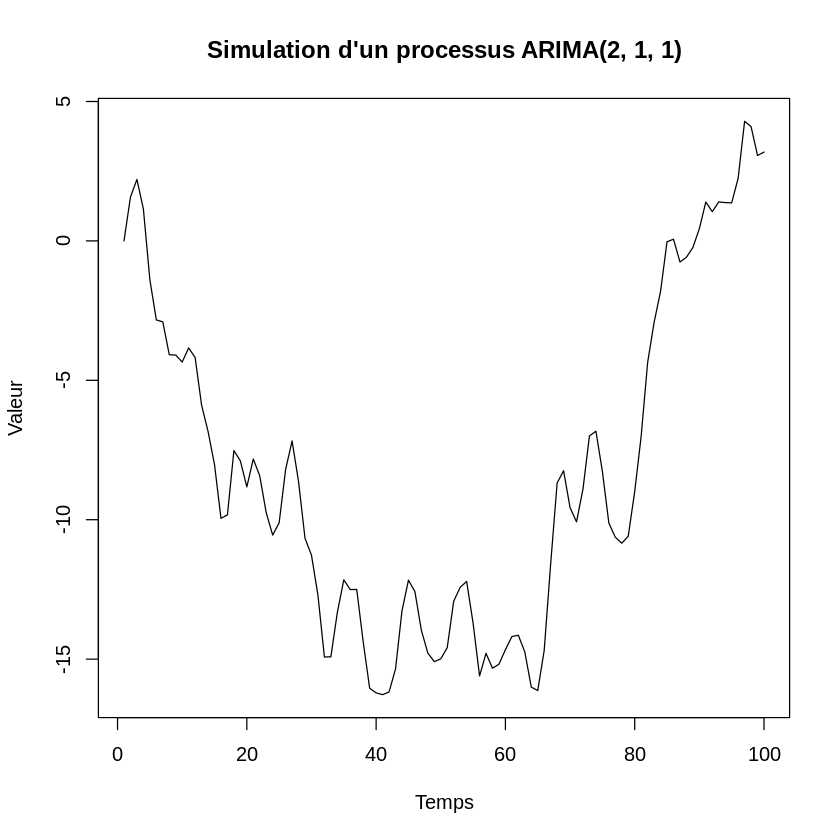

In [9]:
# Exemple d'utilisation de la fonction
set.seed(123456789)  # Pour des résultats reproductibles

# Simulation d'un processus ARIMA(2, 1, 1) avec des coefficients spécifiés
n <- 100  # Longueur de la série simulée
p <- 2    # Ordre du modèle AR
d <- 1    # Différentiation d'ordre 1
q <- 1    # Ordre du modèle MA

# Coefficients pour AR(2) et MA(1)
ar_coeffs <- c(0.5, -0.3)
ma_coeffs <- c(0.4)

# Simulation
sim_data <- Arima_sim(n, p, d, q, ar_coeffs, ma_coeffs, sigma = 1)

# Visualisation de la série simulée
plot.ts(sim_data, main = "Simulation d'un processus ARIMA(2, 1, 1)", ylab = "Valeur", xlab = "Temps")

In [11]:
# Fonction Forecast_Per pour générer des prévisions sans utiliser forecast()
Forecast_Per <- function(model, h) {

  # Extraire les paramètres du modèle ajusté
  fitted_values <- fitted(model)   # Valeurs ajustées par le modèle
  residuals <- residuals(model)    # Résidus du modèle
  coefs <- coef(model)             # Coefficients du modèle ARIMA
  p <- model$arma[1]               # Ordre AR
  q <- model$arma[2]               # Ordre MA
  n <- length(fitted_values)       # Longueur de la série historique
  forecast_values <- numeric(h)    # Stocker les prévisions
  errors <- numeric(h)             # Stocker les erreurs futures (initialement zéro)

  # Dernière valeur de la série ajustée (utilisée pour la première prévision)
  last_value <- fitted_values[n]

  # Générer des prévisions pour les h périodes suivantes
  for (i in 1:h) {
    # Partie AR (autorégressive) : Contribution des valeurs passées ajustées
    ar_part <- 0
    if (p > 0) {
      for (j in 1:p) {
        if ((n + i - j) > 0) {
          ar_part <- ar_part + coefs[j] * (ifelse((n + i - j) <= n, fitted_values[n + i - j], forecast_values[i - j]))
        }
      }
    }

    # Partie MA (moyenne mobile) : Contribution des erreurs passées
    ma_part <- 0
    if (q > 0) {
      for (j in 1:q) {
        if ((n + i - j) > 0) {
          ma_part <- ma_part + coefs[p + j] * (ifelse((n + i - j) <= n, residuals[n + i - j], errors[i - j]))
        }
      }
    }

    # Calcul de la prévision en ajoutant à la dernière valeur ajustée
    if (i == 1) {
      # Pour la première prévision, on part de la dernière valeur ajustée
      forecast_values[i] <- last_value + ar_part + ma_part
    } else {
      # Pour les prévisions suivantes, on utilise la dernière prévision
      forecast_values[i] <- forecast_values[i - 1] + ar_part + ma_part
    }

    # Les erreurs futures sont supposées être nulles pour simplification
    errors[i] <- 0
  }

  # Retourner les prévisions
  return(forecast_values)
}

[1] 3.307047 3.782578


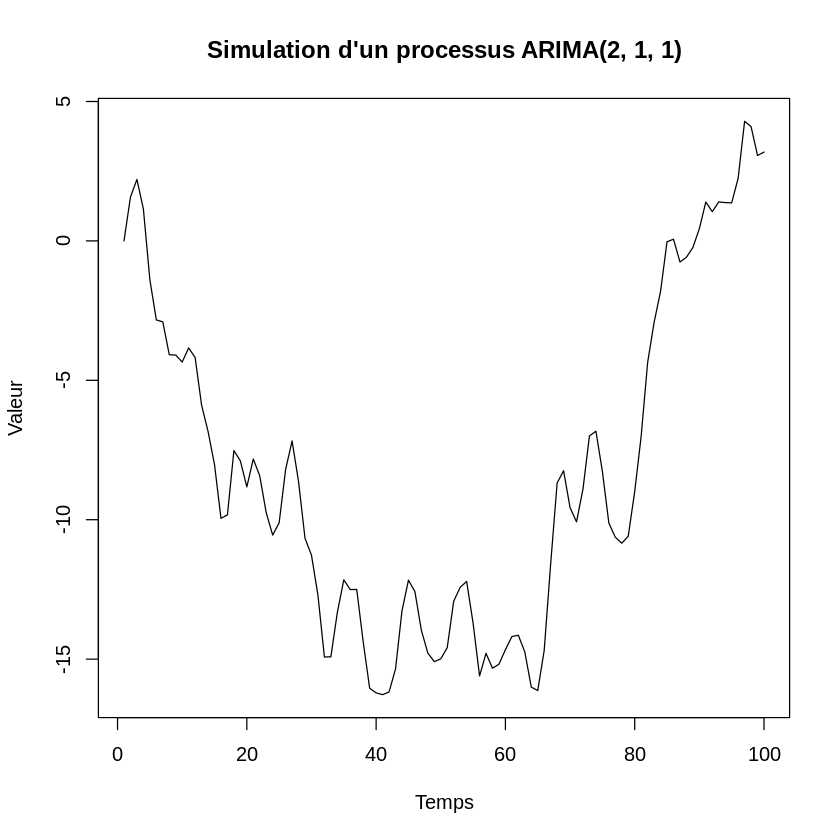

In [12]:
set.seed(123456789)  # Pour des résultats reproductibles

# Simulation d'une série ARIMA(2, 1, 1)
n <- 100  # Longueur de la série
p <- 2    # Ordre AR
d <- 1    # Différentiation d'ordre 1
q <- 1    # Ordre MA

# Coefficients AR et MA
ar_coeffs <- c(0.5, -0.3)
ma_coeffs <- c(0.4)

# Simulation de la série
sim_data <- Arima_sim(n, p, d, q, ar_coeffs, ma_coeffs, sigma = 1)
plot.ts(sim_data, main = "Simulation d'un processus ARIMA(2, 1, 1)", ylab = "Valeur", xlab = "Temps")

model <- Arima(sim_data, order = c(p, 1, q))

# Prévision pour h = 2 périodes
h <- 2  # Horizon de prévision
forecast <- Forecast_Per(model, h)

# Affichage des résultats
print(forecast)

In [14]:
# 1. Simulation d'une série ARIMA(2, 1, 1)
set.seed(123456789)  # Pour des résultats reproductibles
n <- 100  # Longueur de la série
p <- 2    # Ordre AR
d <- 1    # Différentiation d'ordre 1
q <- 1    # Ordre MA
ar_coeffs <- c(0.5, -0.3)
ma_coeffs <- c(0.4)

# Simulation de la série
sim_data <- Arima_sim(n, p, d, q, ar_coeffs, ma_coeffs, sigma = 1)

model <- Arima(sim_data, order = c(p, 1, q), include.constant = FALSE)

# 2. Prévision avec la fonction Forecast_Per (personnalisée)
h <- 2  # Horizon de prévision
forecast_per_custom <- Forecast_Per(model, h)

# 3. Prévisions avec le modèle ajusté via la fonction forecast d'"origine"
forecast_forecast_pkg <- forecast(model, h = h)

# Affichage des résultats
cat("Prévisions avec la fonction Forecast_Per personnalisée:\n")
print(forecast_per_custom)

cat("\nPrévisions avec la fonction Arima du package forecast:\n")
print(forecast_forecast_pkg$mean)

# Comparaison des résultats des deux méthodes
comparison <- data.frame(
  Horizon = 1:h,
  Forecast_Per_Custom = forecast_per_custom,
  Forecast_Forecast_Package = forecast_forecast_pkg$mean
)

# Affichage des résultats de la comparaison
print(comparison)

Prévisions avec la fonction Forecast_Per personnalisée:
[1] 3.307047 3.782578

Prévisions avec la fonction Arima du package forecast:
Time Series:
Start = 101 
End = 102 
Frequency = 1 
[1] 3.572922 3.662321
  Horizon Forecast_Per_Custom Forecast_Forecast_Package
1       1            3.307047                  3.572922
2       2            3.782578                  3.662321


# Partie 2 : Pratique sur un Jeu de Données Réel

## Le jeu de données

,DateTime,Vehicles
,<dttm>,<int>
1,2015-11-01 00:00:00,15
2,2015-11-01 01:00:00,13
3,2015-11-01 02:00:00,10
4,2015-11-01 03:00:00,7
5,2015-11-01 04:00:00,9
6,2015-11-01 05:00:00,6


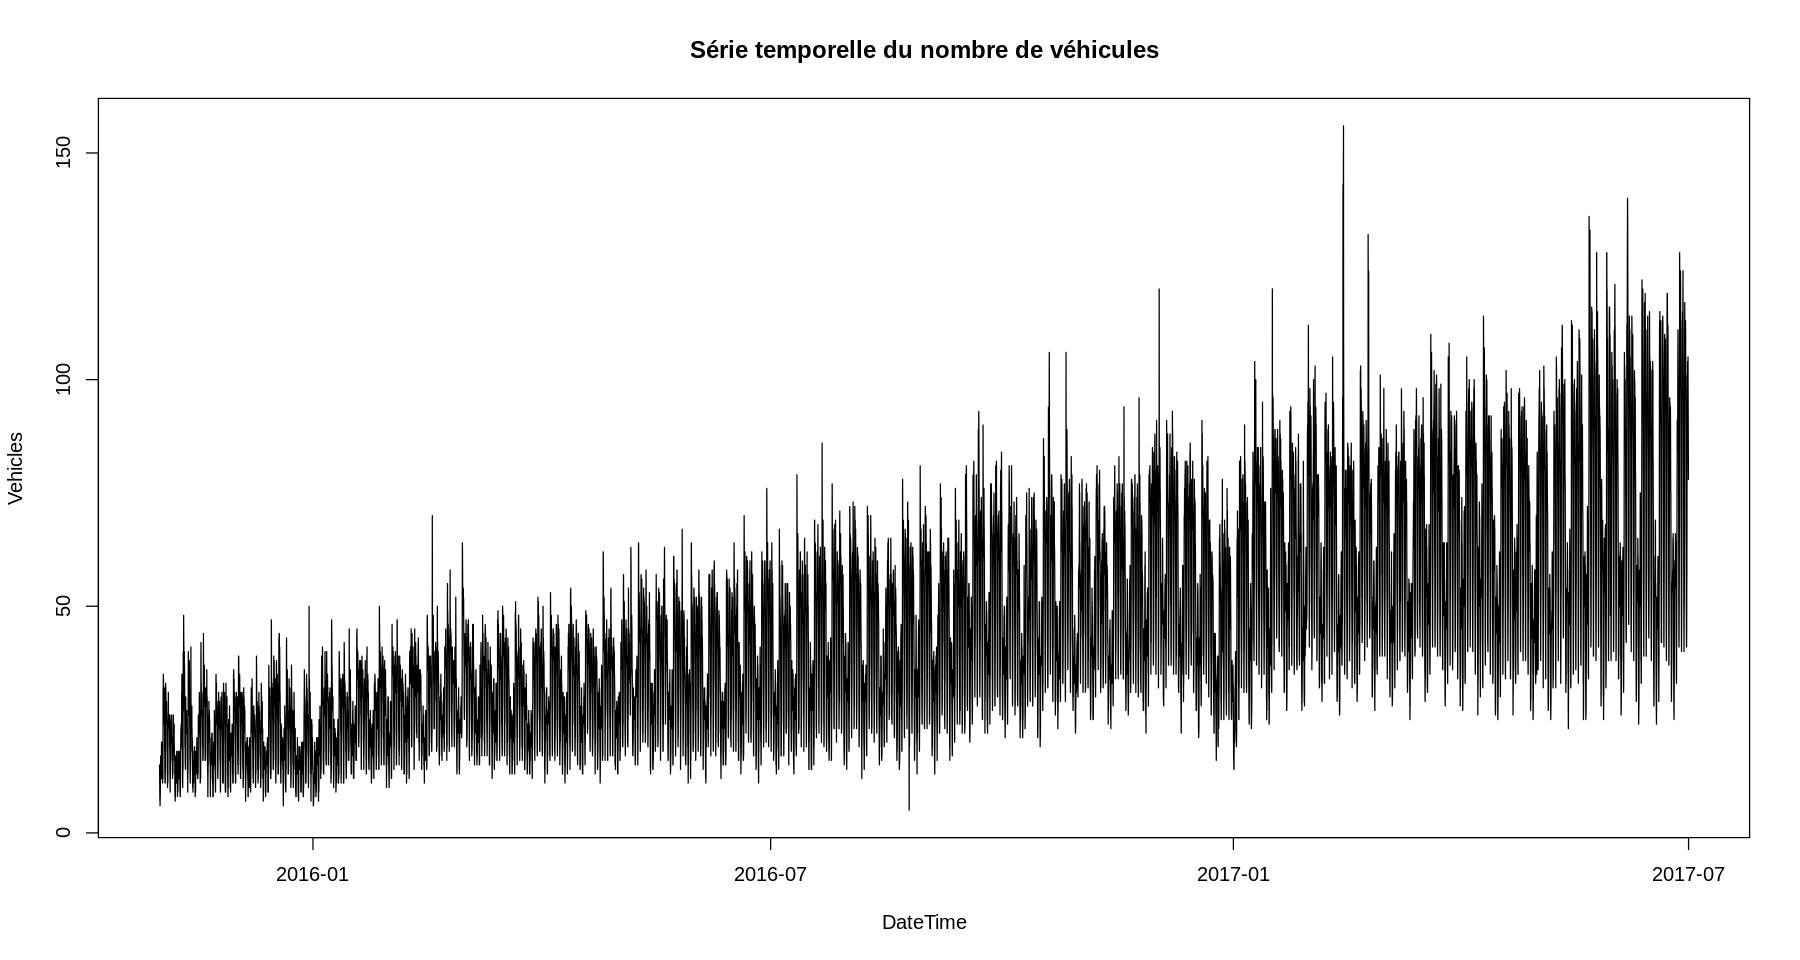

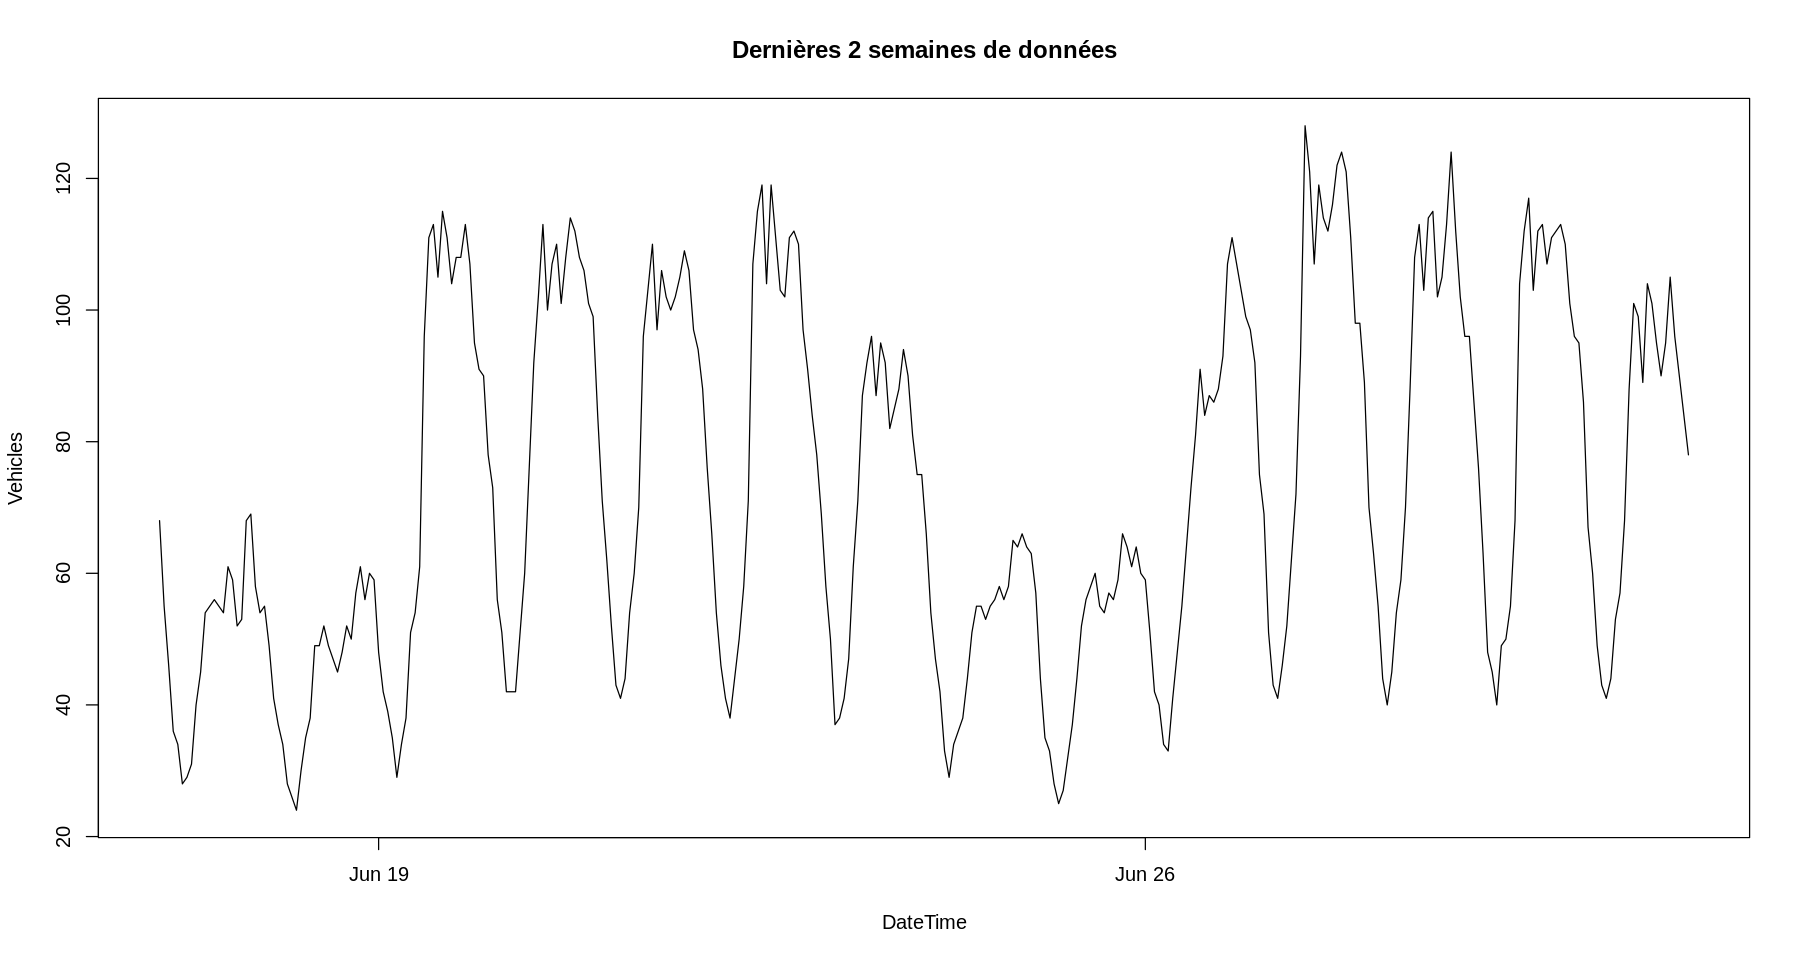

In [ ]:
# Chargement du jeu de données
traffic_data <- read.csv("traffic.csv")

# Filtrage des données pour ne garder que les lignes où Junction est égale à 1
traffic_data <- subset(traffic_data, Junction == 1)
traffic_data <- traffic_data[, !(names(traffic_data) %in% c("Junction", "ID"))]

# Conversion de la colonne DateTime en objet POSIXct pour gérer les dates et heures
traffic_data$DateTime <- as.POSIXct(traffic_data$DateTime, format="%Y-%m-%d %H:%M:%S")

# Visualisation de l'entête des données filtrées pour mieux comprendre la structure
head(traffic_data)

# Visualisation de la série temporelle du nombre de véhicules
options(repr.plot.width=15, repr.plot.height=8)  # Ajustement de la taille de la figure
plot(traffic_data$DateTime, traffic_data$Vehicles, type = "l", xlab = "DateTime", ylab = "Vehicles", main = "Série temporelle du nombre de véhicules")

# Visualisation des 2 dernières semaines de données
last_2_weeks <- tail(traffic_data, 24*7*2)  # Sélection des 2 dernières semaines (24 heures * 7 jours * 2 semaines)
plot(last_2_weeks$DateTime, last_2_weeks$Vehicles, type = "l", xlab = "DateTime", ylab = "Vehicles", main = "Dernières 2 semaines de données")

# Création de la série temporelle avec les données horaires
traffic_ts <- ts(traffic_data$Vehicles, start = c(traffic_data$DateTime[1]), frequency = 24)  # Données horaires

In [ ]:
is.unsorted(index(traffic_ts))

[1] FALSE

## Utilisation des méthodes de référence

## ARIMA et SARIMA

In [ ]:
# 1. Stationnarisation éventuelle de la série
ts_stationarity_test <- adf.test(traffic_ts)
print(ts_stationarity_test)

Warning message in adf.test(traffic_ts):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  traffic_ts
Dickey-Fuller = -14.243, Lag order = 24, p-value = 0.01
alternative hypothesis: stationary



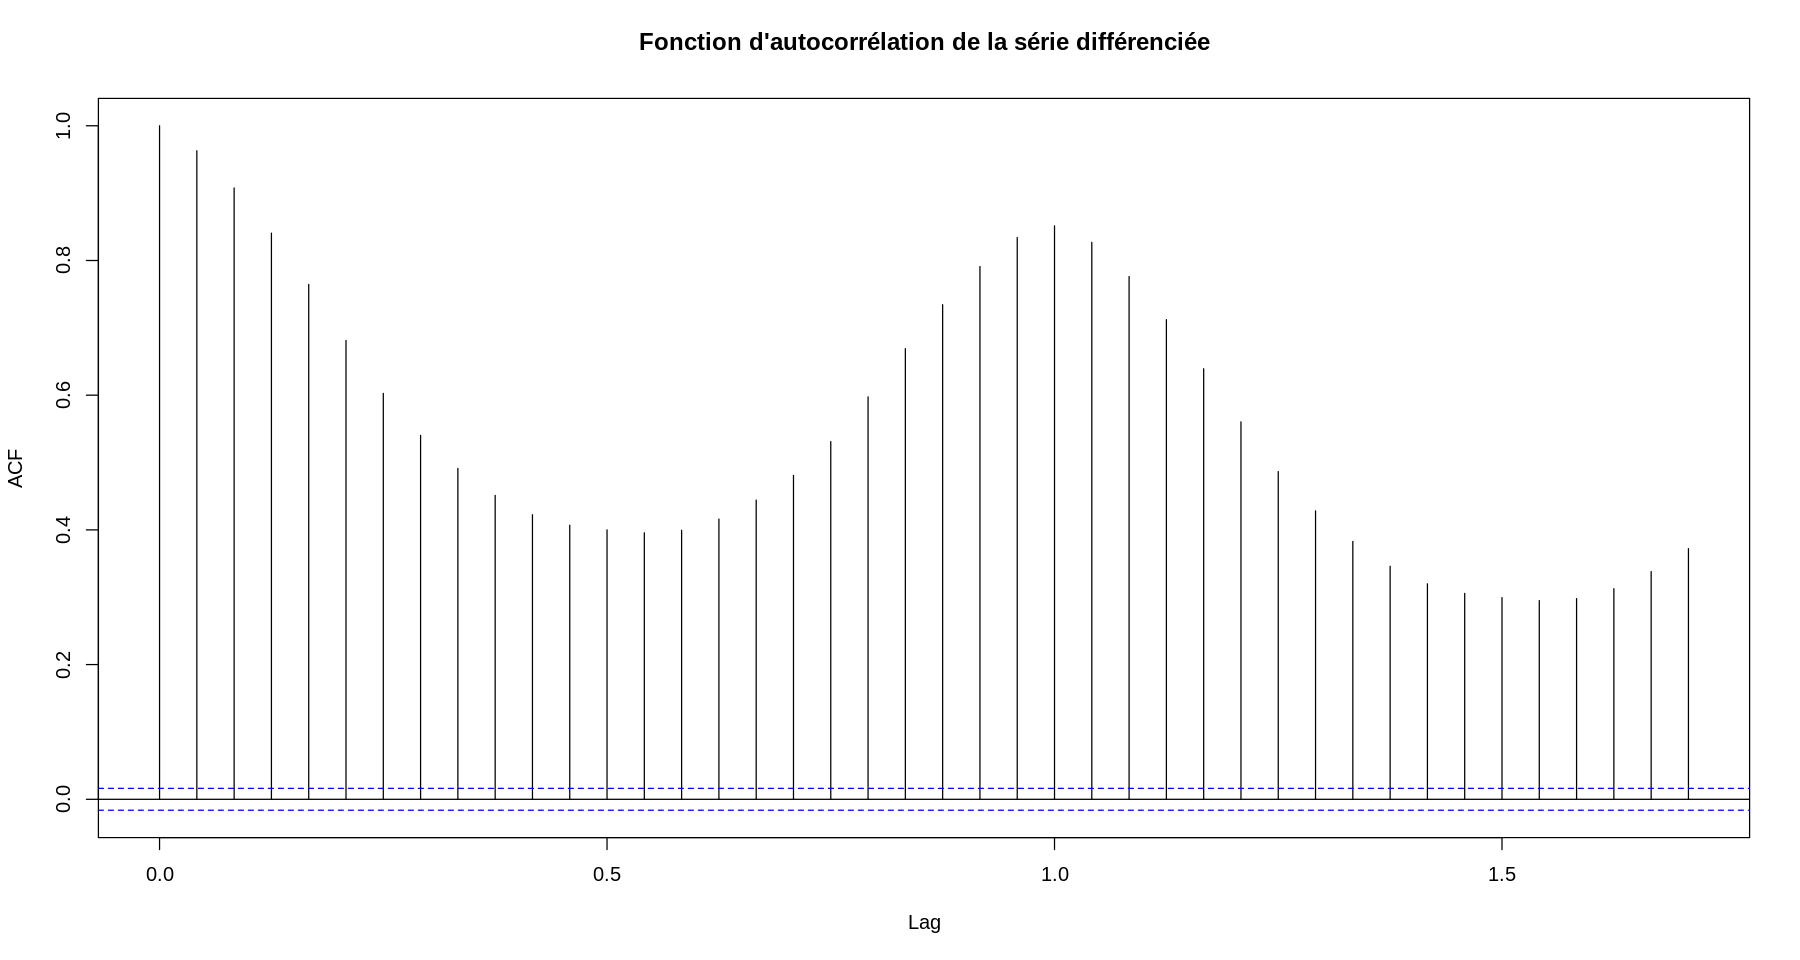

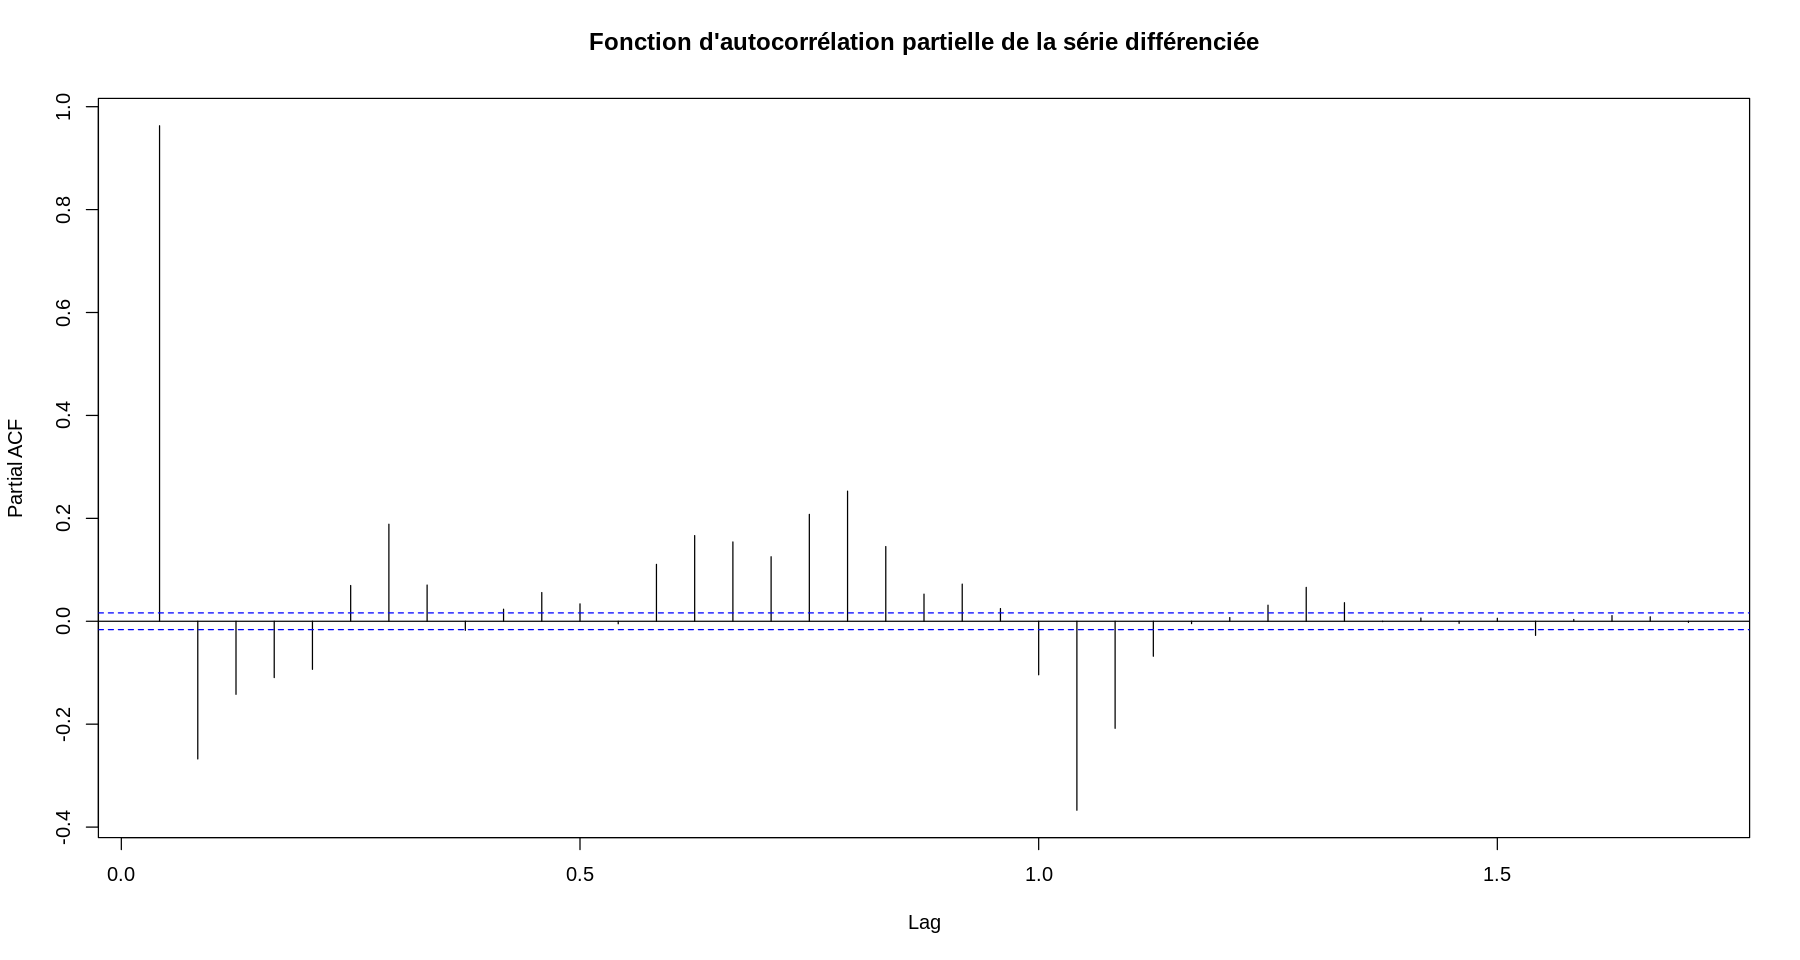

In [ ]:
# 2. Identification a priori des modèles potentiels
# Identification des ordres possibles avec les graphiques ACF et PACF
acf(traffic_ts, main = "Fonction d'autocorrélation de la série différenciée")
pacf(traffic_ts, main = "Fonction d'autocorrélation partielle de la série différenciée")


In [ ]:
# 3. Estimation des paramètres du modèle
# Utilisation de auto.arima pour obtenir un modèle ARIMA potentiellement adéquat
model_arima <- auto.arima(traffic_ts) #7 minutes d execution
print(model_arima)

Series: traffic_ts 
ARIMA(5,0,2)(2,1,0)[24] 

Coefficients:
         ar1      ar2     ar3      ar4     ar5      ma1     ma2     sar1
      2.2098  -1.6412  0.4177  -0.0485  0.0477  -1.4815  0.7110  -0.5943
s.e.  0.0014   0.0036  0.0050   0.0072  0.0043   0.0063  0.0064   0.0014
         sar2
      -0.3145
s.e.   0.0011

sigma^2 = 21.87:  log likelihood = -43145.58
AIC=86311.17   AICc=86311.18   BIC=86387.03


Warning message in zoo(coredata(x), tt):
“some methods for “zoo” objects do not work if the index entries in ‘order.by’ are not unique”
Warning message in zoo(, tt2):
“some methods for “zoo” objects do not work if the index entries in ‘order.by’ are not unique”


ERROR: Error in merge.zoo(zoo(coredata(x), tt), zoo(, tt2), fill = fill): series cannot be merged with non-unique index entries in a series


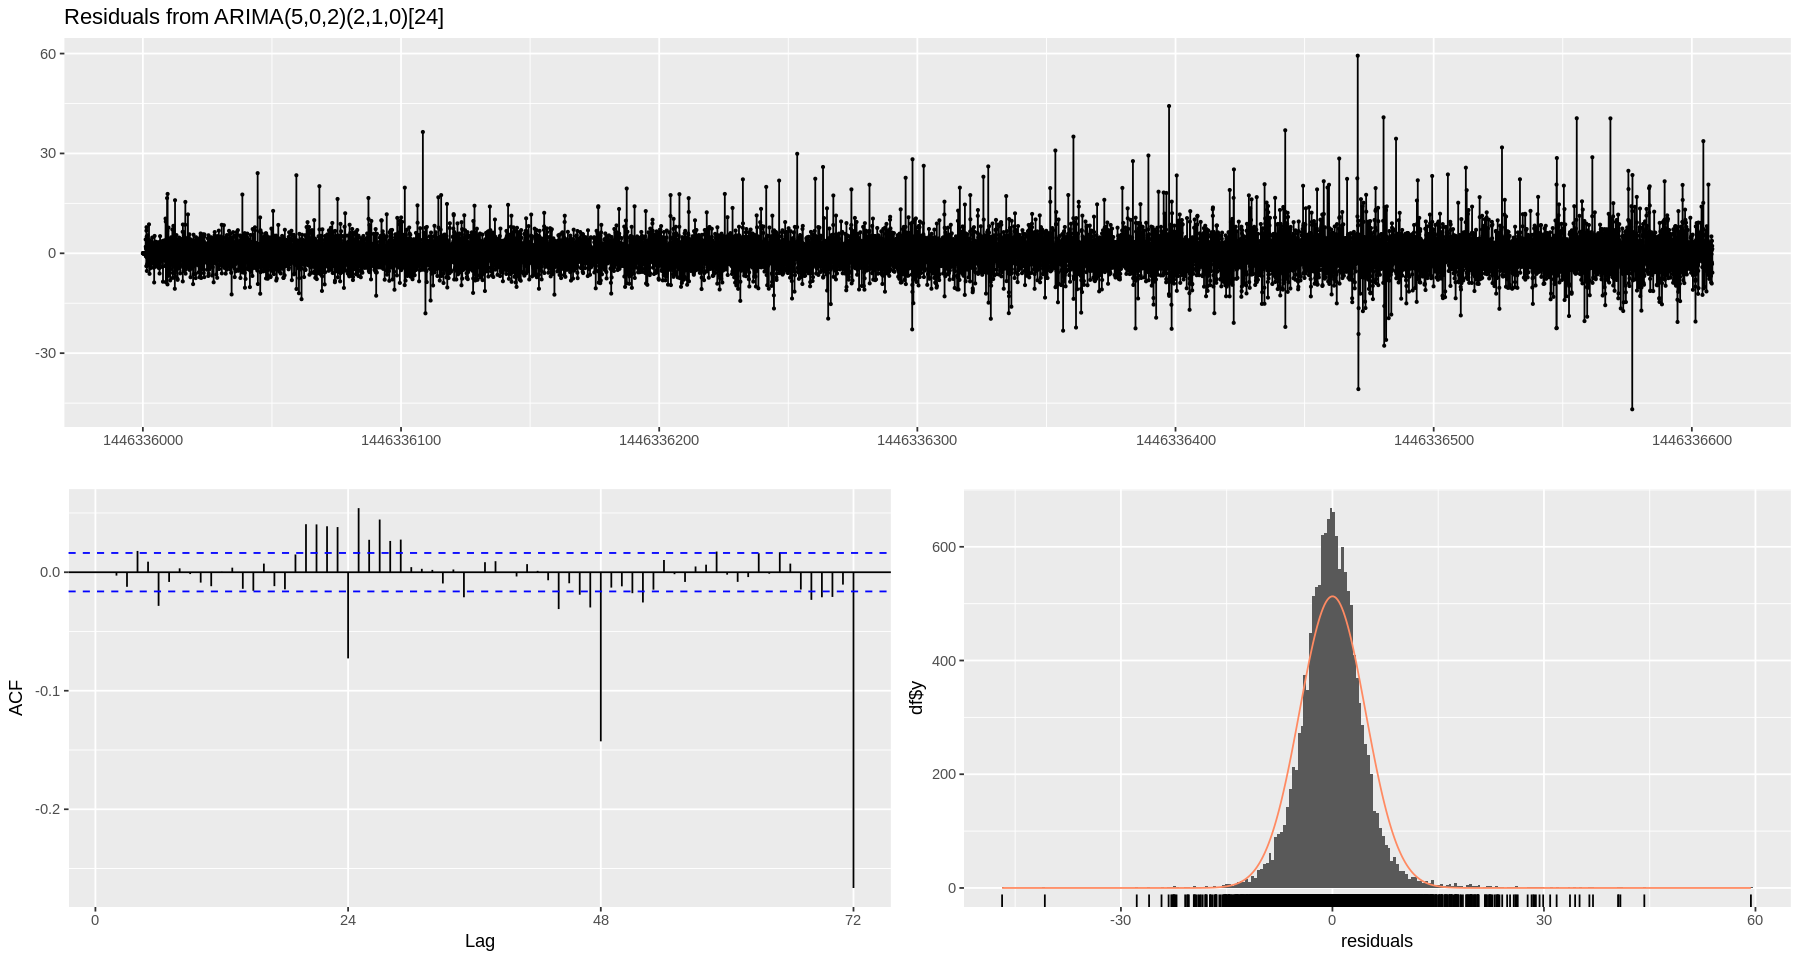

In [ ]:
# 4. Vérification des résidus du modèle
# Vérification si les résidus du modèle sont du bruit blanc
checkresiduals(model_arima)

In [ ]:
# 5. Choix définitif du modèle en donnant la forme explicite de son équation
# Le modèle choisi est celui obtenu via auto.arima
cat("Le modèle ARIMA choisi est :", model_arima$arma, "\n")

Le modèle ARIMA choisi est : 5 2 2 0 24 0 1 


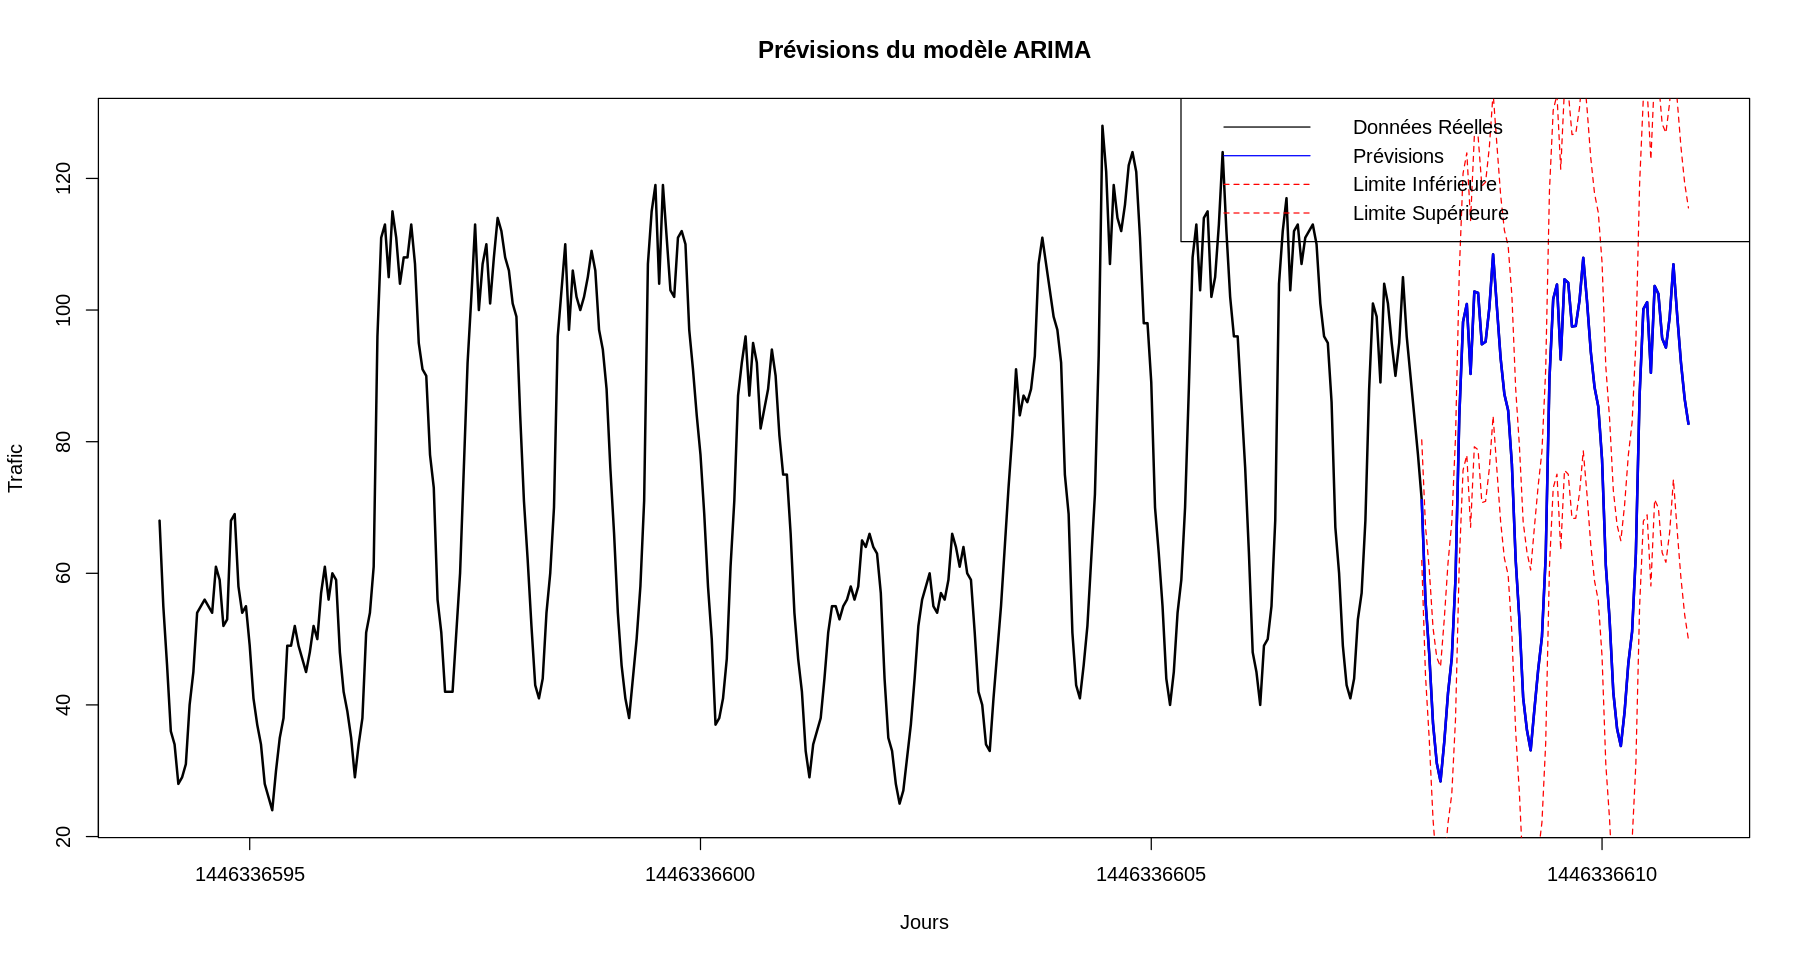

In [ ]:
# Prévision à l'aide du modèle choisi pour 1 jour (24 heures)
forecast_arima <- forecast(model_arima, h = 3 * 24)  # Prévisions pour les 3 prochains jours

# Récupérer les dernières données réelles (dernières 24 heures)
# Adaptez cette ligne pour obtenir les données des deux dernières semaines
last_data_points <- tail(traffic_ts, 14 * 24 )  # Dernières 14 jours (336 valeurs si une donnée par heure)

# Combiner les données réelles et les prévisions
combined_ts <- ts(c(last_data_points, forecast_arima$mean), start = start(last_data_points), frequency = frequency(traffic_ts))

# Tracer
plot(combined_ts, main = "Prévisions du modèle ARIMA", xlab = "Jours", ylab = "Trafic", col = "black", lwd = 2)
lines(forecast_arima$mean, col = "blue", lwd = 2)

# Ajouter les limites inférieures et supérieures
lines(forecast_arima$lower[, 2], col = "red", lty = 2)  # Limite inférieure
lines(forecast_arima$upper[, 2], col = "red", lty = 2)  # Limite supérieure

# Ajouter une légende
legend("topright", legend = c("Données Réelles", "Prévisions", "Limite Inférieure", "Limite Supérieure"),
       col = c("black", "blue", "red", "red"), lty = c(1, 1, 2, 2))



,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.01260138,4.671641,3.326743,-0.7905241,8.737512,0.4103501,-0.0005209763


Series: traffic_ts 
ARIMA(5,0,2)(2,1,0)[24] 

Coefficients:
         ar1      ar2     ar3      ar4     ar5      ma1     ma2     sar1
      2.2098  -1.6412  0.4177  -0.0485  0.0477  -1.4815  0.7110  -0.5943
s.e.  0.0014   0.0036  0.0050   0.0072  0.0043   0.0063  0.0064   0.0014
         sar2
      -0.3145
s.e.   0.0011

sigma^2 = 21.87:  log likelihood = -43145.58
AIC=86311.17   AICc=86311.18   BIC=86387.03


Warning message in zoo(coredata(x), tt):
“some methods for “zoo” objects do not work if the index entries in ‘order.by’ are not unique”
Warning message in zoo(, tt2):
“some methods for “zoo” objects do not work if the index entries in ‘order.by’ are not unique”


ERROR: Error in merge.zoo(zoo(coredata(x), tt), zoo(, tt2), fill = fill): series cannot be merged with non-unique index entries in a series


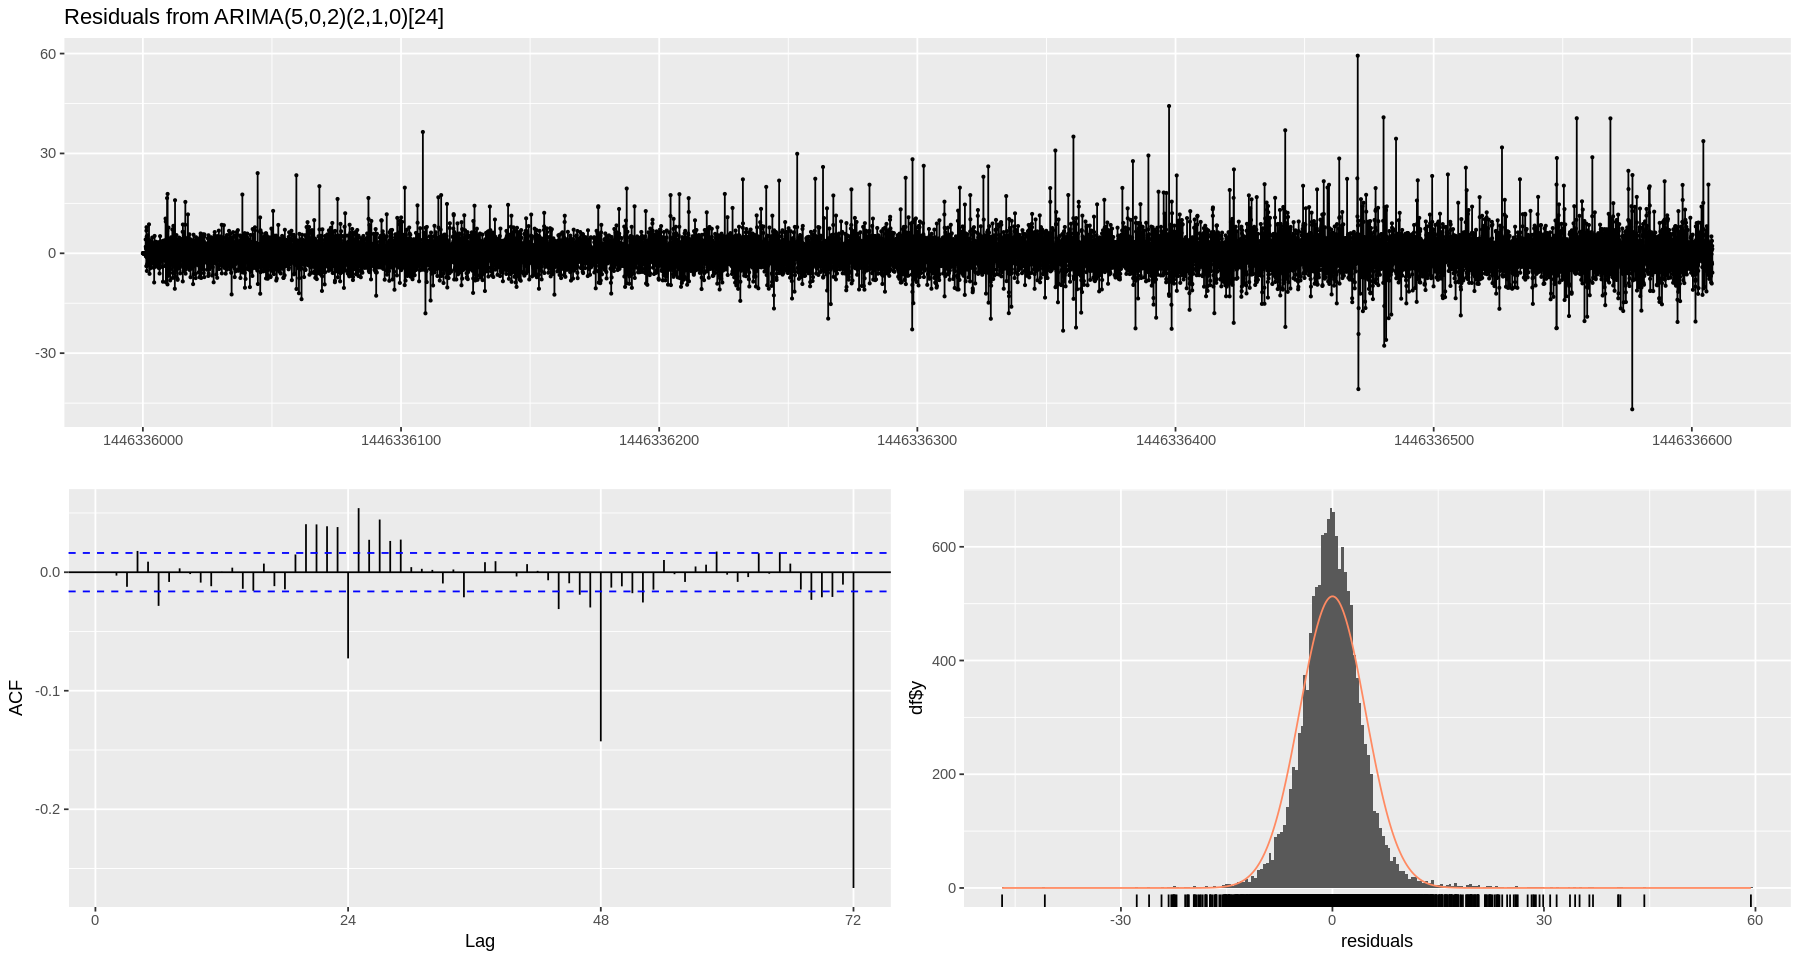

In [ ]:
# 7. Analyse a posteriori de la prévision
# Comparaison des prévisions avec la série réelle (si des données futures sont disponibles)
accuracy(forecast_arima)

# Utilisation du modèle SARIMA si une saisonnalité est présente
# Identification de la saisonnalité (fréquence trimestrielle déjà spécifiée dans ts())
model_sarima <- auto.arima(traffic_ts, seasonal = TRUE)
print(model_sarima)

# Vérification des résidus du modèle SARIMA
checkresiduals(model_sarima)

# Prévision avec le modèle SARIMA
forecast_sarima <- forecast(model_sarima, h = 8)
plot(forecast_sarima, main = "Prévisions du modèle SARIMA")

# Comparaison de la précision des deux modèles
accuracy(forecast_sarima)
accuracy(forecast_arima)

## Analyse des résultats obtenus

### 1. Stationnarisation de la série
- **Test de stationnarité Augmented Dickey-Fuller (ADF)** :
  - Pour la série originale `traffic_ts`, le test ADF donne un **p-value inferrieure à 0.01**. Cela indique que la série est **stationnaire** car la p-value est inferieur au seuil commun de 0.05.

### 2. Identification des Modèles Potentiels
- Les graphiques ACF et PACF ont été utilisés pour aider à identifier des modèles potentiels. Cependant, la sélection automatique via `auto.arima` a été réalisée pour trouver les paramètres optimaux.

### Estimation des Paramètres du Modèle

Le modèle proposé est un modèle **ARIMA(5,0,2)(2,1,0)[24]**, indiquant les éléments suivants :

- **Ordre non saisonnier :**
  - **ARIMA(5,0,2)** : Cela signifie qu'il y a 5 termes autoregressifs (AR) et 2 termes de moyenne mobile (MA) dans le modèle, sans différenciation non saisonnière (d = 0).

- **Ordre saisonnier :**
  - **(2,1,0)[24]** : Il y a 2 termes autoregressifs saisonniers (SAR), une différenciation saisonnière (D = 1), et pas de terme de moyenne mobile saisonnier (SMA = 0), pour une périodicité de 24.


### Coefficients :
- **AR** :  
  - AR1 : 2.2098 (s.e. 0.0014)  
  - AR2 : -1.6412 (s.e. 0.0036)  
  - AR3 : 0.4177 (s.e. 0.0050)  
  - AR4 : -0.0485 (s.e. 0.0072)  
  - AR5 : 0.0477 (s.e. 0.0043)  

- **MA** :  
  - MA1 : -1.4815 (s.e. 0.0063)  
  - MA2 : 0.7110 (s.e. 0.0064)  

- **SAR** :  
  - SAR1 : -0.5943 (s.e. 0.0014)  
  - SAR2 : -0.3145 (s.e. 0.0011)  


### 4. Vérification des Résidus du Modèle
- A faire

### 5. Choix du Modèle
- A faire

### 6. Prévisions avec le Modèle Choisi
- A faire

### 7. Analyse des Prévisions
- A faire

### Conclusion
- A faire